# Imports

In [4]:
import sys
import os

# Dynamically add the root directory to sys.path
# Assumes that 'models' and 'utils' are in the same project root directory
project_root = os.path.abspath(os.path.join(os.path.dirname('.'), '..'))
sys.path.insert(0, project_root)


In [2]:
# sklearn
from sklearn.metrics import accuracy_score

# torch
import torch 
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# torch eeg library
from torcheeg import transforms
from torch.utils.data import DataLoader
from torcheeg.datasets.constants import DREAMER_CHANNEL_LOCATION_DICT
from torcheeg.datasets import DREAMERDataset
from torcheeg.model_selection import KFoldGroupbyTrial
from torcheeg.model_selection import train_test_split_groupby_trial

# Other
import math
from tqdm import tqdm
import matplotlib.pyplot as plt

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Local Imports
from utils.checkpoint import train_and_save
from utils.log import get_logger
from utils.utils import print_var, train_one_epoch, train_one_epoch_lstm, get_num_params, train_one_step_tqdm
from models.cnn import Two_Layer_CNN, Two_Layer_CNN_Pro, Simplified_CNN
from models.rnns import LSTM

In [3]:
from torcheeg.models import TSCeption


In [4]:
# nice label transform
label_transform=transforms.Compose([
    transforms.Select(['valence', 'arousal']),
    transforms.Binary(5.0),
    transforms.BinariesToCategory()])

In [5]:
import json
import os

run_file = f'./run_numbers.json'
emotion_dim = 'val'
model_name = 'aa'

# Load or initialize run numbers
if os.path.exists(run_file):
    with open(run_file, 'r') as file:
        run_numbers = json.load(file)
else:
    run_numbers = {}

# Ensure the emotion_dim exists and initialize it as a dictionary if necessary
if emotion_dim not in run_numbers:
    run_numbers[emotion_dim] = {}

# Initialize the model_name if it doesn't exist for the current emotion_dim
if model_name not in run_numbers[emotion_dim]:
    run_numbers[emotion_dim][model_name] = 0

# Increment the run number for the current model_name and emotion_dim
run_numbers[emotion_dim][model_name] += 1    


# Save the updated run numbers back to the file
with open(run_file, 'w') as file:
    json.dump(run_numbers, file, indent=4)

print(f"Run number for {emotion_dim} and {model_name}: {run_numbers[emotion_dim][model_name]}")
print(run_numbers[emotion_dim][model_name])


Run number for val and aa: 13
13


# load data Base

In [6]:
dataset_name = 'Dreamer_time_series_01'
emotion_dim = 'valence'  # valence, dominance, or arousal

mat_path = '../raw_data/DREAMER.mat'  # path to the DREAMER.mat file
io_path = f'../saves/datasets/{dataset_name}'  # IO path to store the dataset

# Import data
dataset = DREAMERDataset(io_path=f"{io_path}",
                        mat_path=mat_path,
                        offline_transform=transforms.Compose([
                            transforms.MeanStdNormalize(),#MeanStdNormalize() , MinMaxNormalize()
                        ]),
                        online_transform=transforms.Compose([
                            transforms.ToTensor(),
                        ]),
                        label_transform=transforms.Compose([
                            transforms.Select(emotion_dim),
                            transforms.Binary(threshold=2.5),
                             
                        ]),
                        chunk_size=128,
                        baseline_chunk_size=128,
                        num_baseline=61,
                        num_worker=4)



[2024-11-27 14:31:49] INFO (torcheeg/MainThread) 🔍 | Detected cached processing results, reading cache from ../saves/datasets/Dreamer_time_series_01.


# Read data To2D

In [ ]:
# To 2D for tsception

dataset_name = 'Dreamer_2D_1'
emotion_dim = 'valence'  # valence, dominance, or arousal

mat_path = '../raw_data/DREAMER.mat'  # path to the DREAMER.mat file
io_path = f'../saves/datasets/{dataset_name}'  # IO path to store the dataset

dataset = DREAMERDataset(io_path=f"{io_path}",
                         mat_path=mat_path,
                         offline_transform=transforms.Compose([
                             transforms.BaselineRemoval(),
                             transforms.MeanStdNormalize(),
                             transforms.To2d()
                         ]),
                         online_transform=transforms.ToTensor(),
                         label_transform=transforms.Compose([
                             transforms.Select('valence'),
                             transforms.Binary(3.0)
                         ]),
                         chunk_size=128,
                         baseline_chunk_size=128,
                         num_baseline=61,
                         num_worker=4)

[2024-11-27 14:10:38] INFO (torcheeg/MainThread) 🔍 | Detected cached processing results, reading cache from ../saves/datasets/Dreamer_2D_1.


In [7]:
dataset[0][0].shape

torch.Size([14, 128])

IndexError: index 1 is out of bounds for dimension 0 with size 1

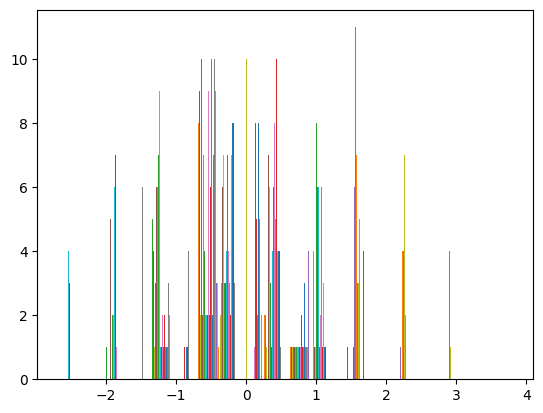

In [35]:
for i in range(14):
    plt.hist(dataset[100][0][i,:])


# Preprocess and split data and create data loader

## Split data

In [7]:
rng_num = 122
train_dataset, test_dataset = train_test_split_groupby_trial(dataset= dataset, test_size = 0.2, shuffle= True, random_state= rng_num)
train_dataset, val_dataset = train_test_split_groupby_trial(dataset= train_dataset, test_size = 0.2, shuffle=True, random_state= rng_num)

[2024-11-27 14:31:50] INFO (torcheeg/MainThread) 📊 | Create the split of train and test set.
[2024-11-27 14:31:50] INFO (torcheeg/MainThread) 😊 | Please set split_path to .torcheeg/model_selection_1732705310396_INuXm for the next run, if you want to use the same setting for the experiment.
[2024-11-27 14:31:51] INFO (torcheeg/MainThread) 📊 | Create the split of train and test set.
[2024-11-27 14:31:51] INFO (torcheeg/MainThread) 😊 | Please set split_path to .torcheeg/model_selection_1732705311445_yUCtS for the next run, if you want to use the same setting for the experiment.


In [8]:
len(train_dataset),len(val_dataset) , len(test_dataset), len(dataset)

(54533, 13869, 17342, 85744)

## create dataloader

In [9]:
train_loader = DataLoader(train_dataset, batch_size= 256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size= 256, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size= 256, shuffle=False)

# Define model

In [11]:
next(iter(train_loader))[0].shape

torch.Size([256, 14, 128])

In [12]:
class LSTM_CNN_Model(nn.Module):
    def __init__(self,in_channel=14, hidden_size1=64, hidden_size2= 128, hidden_size_lstm= 256, num_layers= 1, num_classes=1, dropout_prob=0.5):
        super().__init__()
        
        self.dropout = nn.Dropout(dropout_prob)
        self.af = nn.ReLU()
        
        # CNN
        self.conv1 = nn.Conv1d(in_channels= in_channel, out_channels=hidden_size1 , kernel_size= 3 ,padding=1)
        self.bn1 = nn.BatchNorm1d(num_features= hidden_size1)
        self.max_pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(in_channels= hidden_size1, out_channels=hidden_size2 , kernel_size= 3 ,padding=1)
        self.bn2 = nn.BatchNorm1d(num_features= hidden_size2)
        self.max_pool2 = nn.MaxPool1d(4)

        # LSTM
        self.num_layers = num_layers
        self.hidden_size_lstm = hidden_size_lstm
        self.lstm = nn.LSTM(hidden_size2, hidden_size_lstm, num_layers, batch_first=True)


        # fully connected
        self.fc = nn.LazyLinear(num_classes)


    def forward(self, x): # [batch, 14, 128]
        x = self.conv1(x) # [batch, 64, 64]
        x = self.bn1(x)
        x = self.af(x)
        x = self.dropout(x)
        x = self.max_pool1(x) # [batch, 64, 32]

        x = self.max_pool2(self.dropout(self.af(self.bn2(self.conv2(x))))) # [batch, 128, 16] -> F x L

        # lstm section
        x = x.permute(0, 2, 1) # (Batch, Length, features = 128 channels)
        # Initialize hidden state and cell state with random values
        h0 = torch.randn(self.num_layers, x.size(0), self.hidden_size_lstm).to(x.device)
        c0 = torch.randn(self.num_layers, x.size(0), self.hidden_size_lstm).to(x.device)

        # Forward propagate the LSTM
        out, (_,_) = self.lstm(x, (h0, c0)) #

        # x = self.fc(out[:, -1, :])
        x = self.fc(out.flatten(1))
        x = nn.functional.sigmoid(x)

        return x


# Test model with little data

In [279]:
x, y = next(iter(train_loader))
model = LSTM_CNN_Model()
print(model(x).shape)
print(get_num_params(model,1))

torch.Size([256, 1])
423361.0


In [ ]:
from torcheeg.models import TSCeption
# TSCeption config for DREAMER
model = TSCeption(num_electrodes=14,
                    num_classes=2,
                    num_T=15,
                    num_S=15,
                    in_channels=1,
                    hid_channels=32,
                    sampling_rate=128,
                    dropout=0.5)
model(next(iter(dataset))[0])

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [14, 128]

# Optimize learning parameters

# Train

In [28]:
model = LSTM_CNN_Model()
# model = TSCeption(num_electrodes=14,
#                     num_classes=1,
#                     num_T=15,
#                     num_S=15,
#                     in_channels=1,
#                     hid_channels=32,
#                     sampling_rate=128,
#                     dropout=0.5)

loss_fn = nn.BCEWithLogitsLoss()
# loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) # lr = 0.0001

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = model.to(device)

num_epochs = 400 # 300
model_name = model.__class__.__name__
print(f"Start training {model_name} for {num_epochs} epoch")

# Lists to store loss and accuracy values
loss_hist = []
acc_hist = []

# Initialize the best loss variable to track the least loss
best_loss = float('inf')  # Set to infinity initially to ensure it gets updated in the first epoch


for epoch in range(num_epochs):
    # Model training (assuming train_one_step_tqdm is implemented)
    model, loss, acc = train_one_step_tqdm(model, train_loader, loss_fn, optimizer, device, epoch, True)
    
    loss_hist.append(loss)
    acc_hist.append(acc)

print("Training process is done!")



Using device: cuda
Start training LSTM_CNN_Model for 400 epoch


  0%|          | 0/214 [00:00<?, ?batch/s]

Epoch: 399: 100%|██████████| 214/214 [00:11<00:00, 18.04batch/s, accuracy=95.2, loss=0.486]

Training process is done!


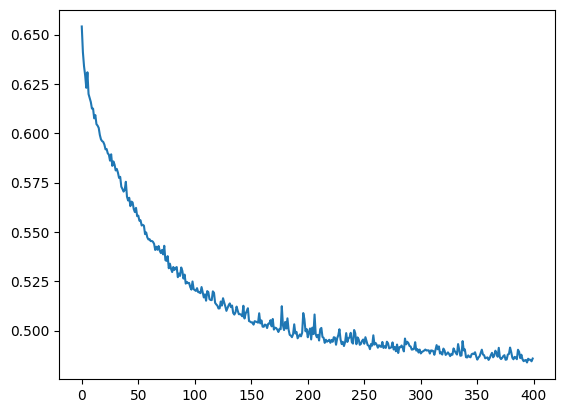

In [29]:
plt.plot(loss_hist)

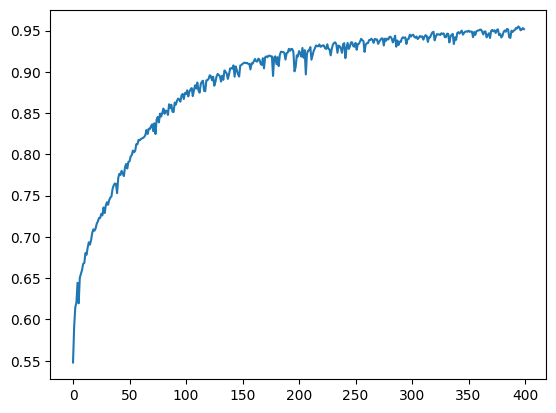

In [30]:
plt.plot(acc_hist)

# TSCeption


In [56]:
class TSCEPTIONModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.tsception = TSCeption(num_electrodes=14,
                        num_classes=1,
                        num_T=15,
                        num_S=15,
                        in_channels=1,
                        hid_channels=32,
                        sampling_rate=128,
                        dropout=0.5)
        
    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.tsception(x)
        return x

model = TSCEPTIONModel()

loss_fn = nn.BCEWithLogitsLoss()
# loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) # lr = 0.0001

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = model.to(device)

num_epochs = 10 # 300
model_name = model.__class__.__name__
print(f"Start training {model_name} for {num_epochs} epoch")

# Lists to store loss and accuracy values
loss_hist = []
acc_hist = []

# Initialize the best loss variable to track the least loss
best_loss = float('inf')  # Set to infinity initially to ensure it gets updated in the first epoch


for epoch in range(num_epochs):
    # Model training (assuming train_one_step_tqdm is implemented)
    model, loss, acc = train_one_step_tqdm(model, train_loader, loss_fn, optimizer, device, epoch, True)
    
    loss_hist.append(loss)
    acc_hist.append(acc)

print("Training process is done!")



Using device: cuda
Start training TSCEPTIONModel for 10 epoch


Epoch: 9: 100%|██████████| 214/214 [00:13<00:00, 15.32batch/s, accuracy=67.5, loss=0.586]

Training process is done!


# EEG Net

In [22]:
# source:  https://github.com/weilheim/EEG/blob/master/model/eegnet.py

from __future__ import absolute_import

import torch
import torch.nn as nn
import torch.nn.functional as F


class EEGNet(nn.Module):
    """2D convolutional neural network for single EEG frame."""
    VALIDENDPOINT = ('logit', 'predict')

    def __init__(self, num_class,
                    input_channel,
                    hidden_size,
                    kernel_size,
                    stride,
                    avgpool_size=4,
                    dropout=0.1):
        super(EEGNet, self).__init__()

        # assert len(kernel_size) == len(hidden_size)
        # assert len(kernel_size) == len(stride)
        self.num_layer = len(kernel_size)
        self.num_class = num_class
        self.input_channel = input_channel
        self.dropout = dropout

        in_channel = self.input_channel
        layer = 1
        self.projections = nn.ModuleList()
        self.residualnorms = nn.ModuleList()
        self.convolutions = nn.ModuleList()
        self.batchnorms = nn.ModuleList()
        for (out_channel, kernel_width, s) in zip(hidden_size, kernel_size, stride):
            pad = (kernel_size - 1) // 2
            self.projections.append(nn.Conv1d(in_channel, out_channel, kernel_size=1, stride=s, bias=False)
                                    if in_channel != out_channel or s != 1 else None)
            self.residualnorms.append(nn.BatchNorm2d(out_channel)
                                        if in_channel != out_channel or s != 1 else None)
            self.convolutions.append(nn.Conv2d(in_channel, out_channel,
                                                kernel_size=kernel_width, stride=s, padding=pad, bias=False))
            self.batchnorms.append(nn.BatchNorm2d(out_channel, eps=1e-5, affine=True))
            in_channel = out_channel
        # avgpool_size should equal to size of the feature map,
        # otherwise self.predict will break.
        self.avgpool = nn.AvgPool2d(kernel_size=avgpool_size)
        self.predict = nn.Linear(hidden_size[-1], self.num_class, bias=True)

    def forward(self, x, endpoint='predict'):
        if endpoint not in self.VALIDENDPOINT:
            raise ValueError('Unknown endpoint {:s}'.format(endpoint))

        for proj, rbn, conv, bn in zip(self.projections, self.residualnorms,
                                    self.convolutions, self.batchnorms):
            if proj is not None:
                residual = proj(x)
                residual = rbn(residual)
            else:
                residual = x
            x = F.dropout(x, p=self.dropout, training=self.training)
            x = conv(x)
            x = bn(x)
            x = (x + residual)
            x = F.relu(x)
        x = self.avgpool(x)
        if endpoint == 'logit':
            return x
        x = self.predict(x)
        return x

In [12]:
from torcheeg.models import EEGNet
model = EEGNet(chunk_size=128,
               num_electrodes=14,
               dropout=0.5,
               kernel_1=64,
               kernel_2=16,
               F1=8,
               F2=16,
               D=2,
               num_classes=1)


In [17]:
x, y = next(iter(DataLoader(dataset, batch_size=64)))
x.shape, y
model(x.unsqueeze(1)).shape

torch.Size([64, 1])

In [10]:
from models.eegnet import EEGNet_Normal_data
model = EEGNet_Normal_data()
x, y = next(iter(DataLoader(dataset, batch_size=64)))
model(x).shape

torch.Size([64, 1])

In [36]:
from models.eegnet import EEGNet_Normal_data
# define model
model = EEGNet_Normal_data()

loss_fn = nn.BCEWithLogitsLoss()
# loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.008) # lr = 0.01    0.001 0.0001

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = model.to(device)

num_epochs = 20 # 300
model_name = model.__class__.__name__
print(f"Start training {model_name} for {num_epochs} epoch")

# Lists to store loss and accuracy values
loss_hist = []
acc_hist = []

# Initialize the best loss variable to track the least loss
best_loss = float('inf')  # Set to infinity initially to ensure it gets updated in the first epoch


for epoch in range(num_epochs):
    # Model training (assuming train_one_step_tqdm is implemented)
    model, loss, acc = train_one_step_tqdm(model, train_loader, loss_fn, optimizer, device, epoch, True)
    
    loss_hist.append(loss)
    acc_hist.append(acc)

print("Training process is done!")



Using device: cuda
Start training EEGNet_Normal_data for 20 epoch


Epoch: 19: 100%|██████████| 214/214 [00:12<00:00, 17.60batch/s, accuracy=62.9, loss=0.631]

Training process is done!


# FFT USING TORCH

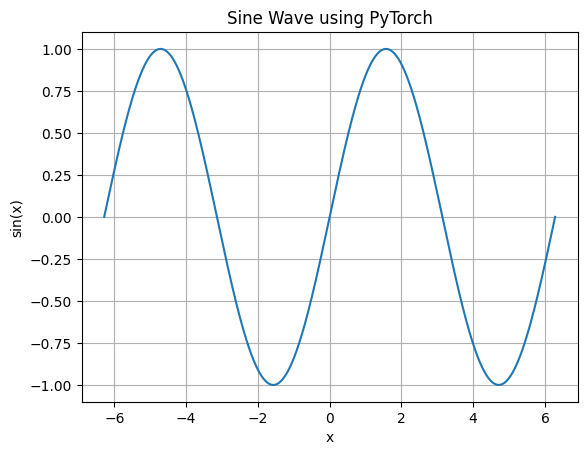

In [23]:
import torch
import matplotlib.pyplot as plt

# Generate values from -2pi to 2pi
x = torch.linspace(-2 * torch.pi, 2 * torch.pi, 1000)

# Compute the sine of each value
y = torch.sin(x)

# Plot the sine wave
plt.plot(x.numpy(), y.numpy())  # Convert torch tensors to numpy for plotting
plt.title("Sine Wave using PyTorch")
plt.xlabel("x")
plt.ylabel("sin(x)")
plt.grid(True)
plt.show()


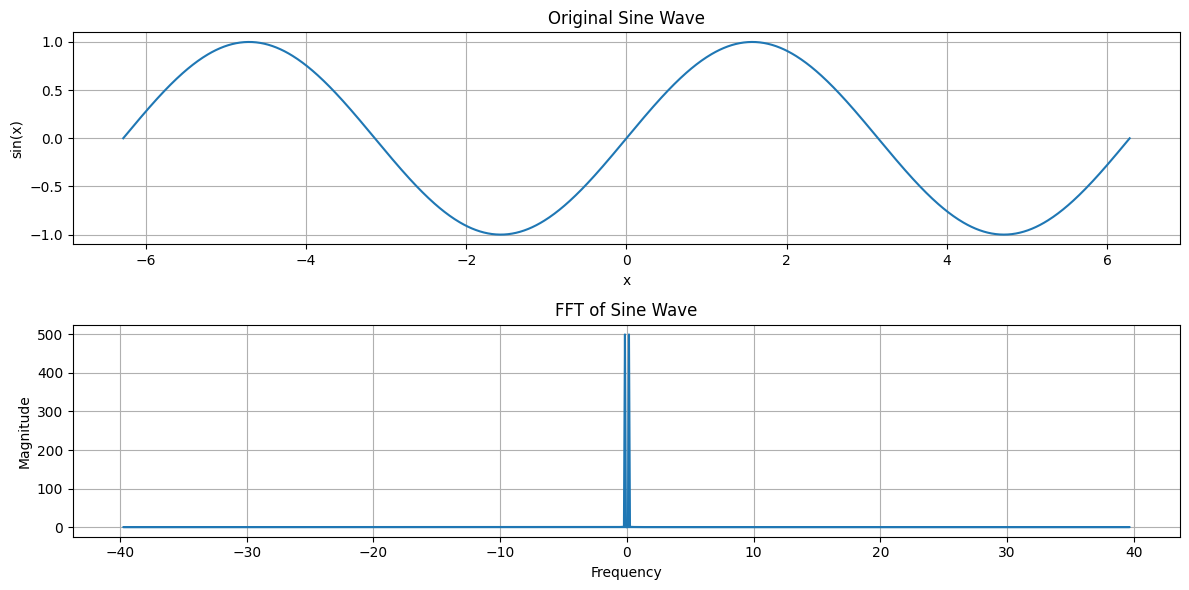

In [24]:
import torch
import matplotlib.pyplot as plt

# Generate values from -2pi to 2pi
x = torch.linspace(-2 * torch.pi, 2 * torch.pi, 1000)

# Compute the sine of each value
y = torch.sin(x)

# Compute the FFT of the sine wave
y_fft = torch.fft.fft(y)

# Get the frequencies corresponding to the FFT
frequencies = torch.fft.fftfreq(len(x), d=(x[1] - x[0]).item())

# Get the magnitude of the FFT (absolute value of complex numbers)
y_fft_magnitude = torch.abs(y_fft)

# Plot the original sine wave
plt.figure(figsize=(12, 6))

# Plot sine wave in time domain
plt.subplot(2, 1, 1)
plt.plot(x.numpy(), y.numpy())
plt.title("Original Sine Wave")
plt.xlabel("x")
plt.ylabel("sin(x)")
plt.grid(True)

# Plot FFT in frequency domain
plt.subplot(2, 1, 2)
plt.plot(frequencies.numpy(), y_fft_magnitude.numpy())
plt.title("FFT of Sine Wave")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.grid(True)

plt.tight_layout()
plt.show()


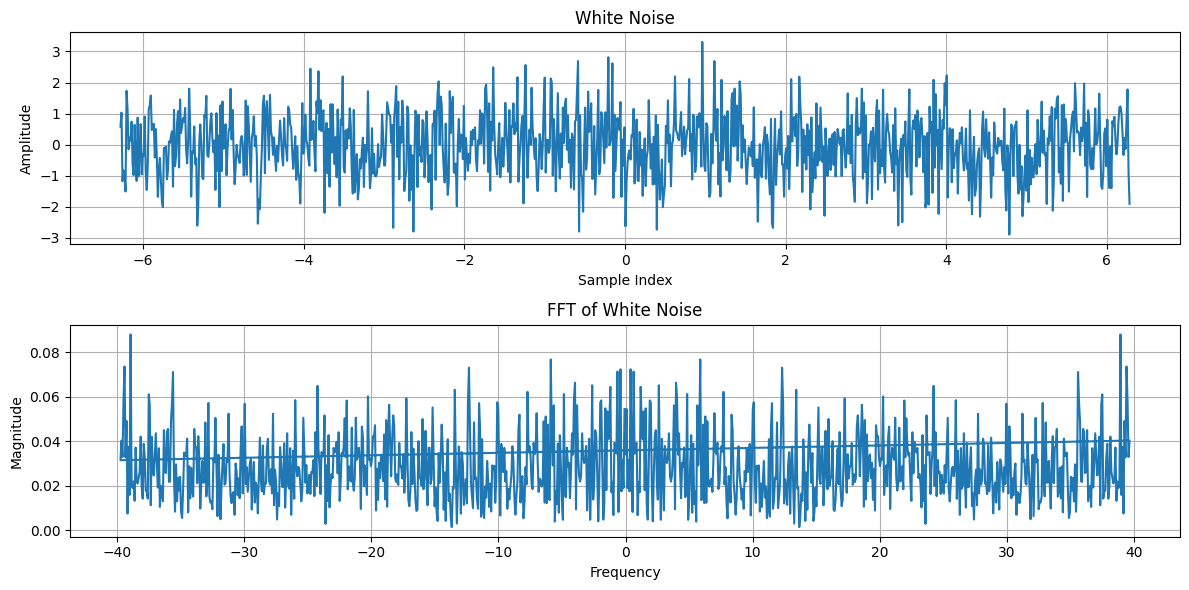

In [34]:
import torch
import matplotlib.pyplot as plt

# Generate white noise: random values from a normal distribution (mean=0, std=1)
x = torch.linspace(-2 * torch.pi, 2 * torch.pi, 1000)
white_noise = torch.randn(1000)  # Standard normal distribution (mean=0, std=1)

# Compute the FFT of the white noise
white_noise_fft = torch.fft.fft(white_noise) / len(white_noise)

# Get the frequencies corresponding to the FFT
frequencies = torch.fft.fftfreq(len(x), d=(x[1] - x[0]).item())

# Get the magnitude of the FFT (absolute value of complex numbers)
white_noise_fft_magnitude = torch.abs(white_noise_fft)

# Plot the white noise and its FFT
plt.figure(figsize=(12, 6))

# Plot white noise in the time domain
plt.subplot(2, 1, 1)
plt.plot(x.numpy(), white_noise.numpy())
plt.title("White Noise")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True)

# Plot FFT of the white noise
plt.subplot(2, 1, 2)
plt.plot(frequencies.numpy(), white_noise_fft_magnitude.numpy())
plt.title("FFT of White Noise")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.grid(True)

plt.tight_layout()
plt.show()


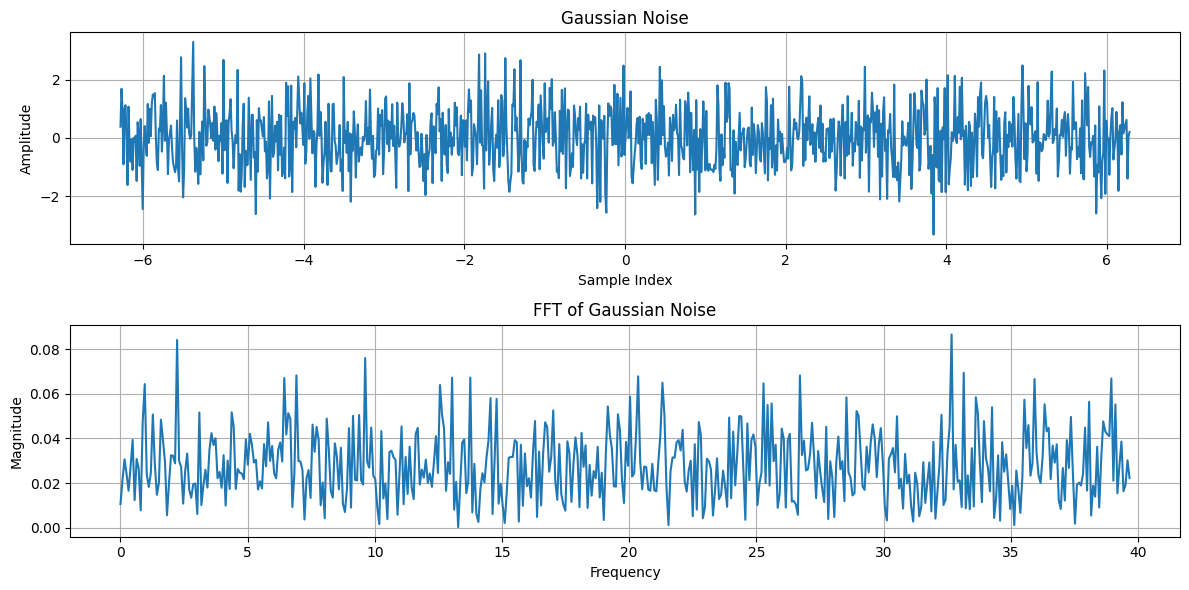

In [33]:
import torch
import matplotlib.pyplot as plt

# Parameters for Gaussian noise
mean = 0.0  # Mean of the Gaussian distribution
std = 1.0   # Standard deviation of the Gaussian distribution

# Generate Gaussian noise: random values from a Gaussian distribution
x = torch.linspace(-2 * torch.pi, 2 * torch.pi, 1000)
gaussian_noise = torch.normal(mean, std, size=(1000,))

# Compute the FFT of the Gaussian noise
gaussian_noise_fft = torch.fft.fft(gaussian_noise)

# Normalize the FFT (divide by the number of samples)
gaussian_noise_fft_normalized = gaussian_noise_fft / len(gaussian_noise)

# Get the frequencies corresponding to the FFT (only the positive frequencies)
frequencies = torch.fft.fftfreq(len(x), d=(x[1] - x[0]).item())
positive_freq_idx = frequencies >= 0
frequencies = frequencies[positive_freq_idx]
fft_magnitude = torch.abs(gaussian_noise_fft_normalized)[positive_freq_idx]

# Plot the Gaussian noise and its FFT
plt.figure(figsize=(12, 6))

# Plot Gaussian noise in the time domain
plt.subplot(2, 1, 1)
plt.plot(x.numpy(), gaussian_noise.numpy())
plt.title("Gaussian Noise")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.grid(True)

# Plot FFT of the Gaussian noise (only positive frequencies)
plt.subplot(2, 1, 2)
plt.plot(frequencies.numpy(), fft_magnitude.numpy())
plt.title("FFT of Gaussian Noise")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.grid(True)

plt.tight_layout()
plt.show()


# Read log files

In [ ]:
import re

# Path to your text file
file_path = '/home/speech/SA_FILES/codes/SirAfshin/EEG_PlayGround/saves/models/Dreamer_time_series_01/Two_Layer_CNN_Pro/logs/report_1_Dreamer_time_series_01_Two_Layer_CNN_Pro_valence.txt'

# Regular expression pattern to match loss and accuracy values
pattern = r"Loss:\s([0-9\.]+),\sAcc:\s([0-9\.]+)"

# Initialize lists to store loss and accuracy values
losses = []
accuracies = []

# Open the file and extract the desired values
with open(file_path, 'r') as file:
    # Read the file line by line
    for line in file:
        # Search for the pattern in the line
        match = re.search(pattern, line)
        if match:
            # Extract the loss and accuracy values and append to lists
            loss = float(match.group(1))
            acc = float(match.group(2))
            losses.append(loss)
            accuracies.append(acc)

# Print the extracted values
print("Loss values:", losses)
print("Accuracy values:", accuracies)


Loss values: [0.6626967896276446, 0.653315441732976, 0.6450795051766866, 0.6376330395243062, 0.6317953536759562, 0.6259659816969686, 0.6218955713421551, 0.6181296038983474, 0.6152409698536146, 0.6119157176409195, 0.6098659803618246, 0.6068000913555942, 0.6034403994012235, 0.6043060462866257, 0.600740417437767, 0.5983815338184585, 0.5969750178394033, 0.5941077657599947, 0.5932796014333839, 0.5917353328484208, 0.5911006671279224, 0.5876966045863593, 0.586642935916559, 0.5839175114435936, 0.5827243221784706, 0.5827847310411396, 0.5827526749959633, 0.5812949558692192, 0.5791999006004476, 0.5760738560068074, 0.576469166688065, 0.5743999591069435, 0.573131381620222, 0.5710915234551501, 0.5715083503456259, 0.5690928729167625, 0.5705340152356162, 0.56968809481877, 0.5662945875925804, 0.5659702301470202, 0.5646786186232495, 0.562780305476331, 0.562908532770712, 0.5620089046545883, 0.5620772944457495, 0.5597210780008516, 0.5579222661790563, 0.5582570548822631, 0.5565415030095114, 0.5571950264386

In [5]:
from utils.utils import get_loss_acc_from_log
file_path = '/home/speech/SA_FILES/codes/SirAfshin/EEG_PlayGround/saves/models/Dreamer_time_series_01/Two_Layer_CNN_Pro/logs/report_1_Dreamer_time_series_01_Two_Layer_CNN_Pro_valence.txt'
get_loss_acc_from_log(file_path)

([0.6626967896276446,
  0.653315441732976,
  0.6450795051766866,
  0.6376330395243062,
  0.6317953536759562,
  0.6259659816969686,
  0.6218955713421551,
  0.6181296038983474,
  0.6152409698536146,
  0.6119157176409195,
  0.6098659803618246,
  0.6068000913555942,
  0.6034403994012235,
  0.6043060462866257,
  0.600740417437767,
  0.5983815338184585,
  0.5969750178394033,
  0.5941077657599947,
  0.5932796014333839,
  0.5917353328484208,
  0.5911006671279224,
  0.5876966045863593,
  0.586642935916559,
  0.5839175114435936,
  0.5827243221784706,
  0.5827847310411396,
  0.5827526749959633,
  0.5812949558692192,
  0.5791999006004476,
  0.5760738560068074,
  0.576469166688065,
  0.5743999591069435,
  0.573131381620222,
  0.5710915234551501,
  0.5715083503456259,
  0.5690928729167625,
  0.5705340152356162,
  0.56968809481877,
  0.5662945875925804,
  0.5659702301470202,
  0.5646786186232495,
  0.562780305476331,
  0.562908532770712,
  0.5620089046545883,
  0.5620772944457495,
  0.559721078000851